# Apply Resolution Function to Simulation Data from LNGS

#### Iffat Zarif

### Import needed libraries

In [1]:
import numpy as np

import ROOT
from ROOT import *
import ctypes
from ctypes import *
from root_numpy import array2hist, hist2array, fill_hist

import sys
import math

import os
from scipy.optimize import *
import pandas as pd
# import seaborn as sns

from datetime import datetime
from glob import glob
from array import array

%cd libs/
from dt5202 import dt5202_crunch # Import parser that Tom wrote. This is containted in the file 
                                 # named dt5202.py in the lib folder.
from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ # Old ver

from langaus import LanGausFit 
%cd -

import warnings
warnings.filterwarnings("ignore")

Welcome to JupyROOT 6.24/02
/vast/palmer/home.grace/iz43/SmearingProjectCUORE/libs
/vast/palmer/home.grace/iz43/SmearingProjectCUORE


### Declare constants

In [2]:
ped = 50 # Pedestal correction for dt5202

# Declare constants for conversion from ADC to PE/MeV
adc_mev = 538.3933387436877 # from "MuonPeakCalibration_Din_ThanksEmily_v1_cut.ipynb"
pe_mev = 53.95 # gotten from averaging two values from "OLD_MuonsAndGammas_SimulationFitting_Din_v2_w_Caesium.ipynb"

sig662 = 0.1601 # Get the sigma in [MeV] from "Cs137_GaussFitting_ForResolution_Din_vz1.ipynb"

hmin = 0.0 # Lower bound of full spectrum hist. (not simulating anything below 500 KeV) [MeV]
hmax = 15 # Upper bound of full spectrum hist. [MeV]
hspl = 2.8 # Approximate division point between gamma/muon spectra
R = 0.07
bins = int((hmax-hmin)/R) # Want the number of bins to be ~250

### Import simulated .root files and lab data

In [3]:
%%capture

%run /home/iz43/SmearingProjectCUORE/libs/Import_Simulated_Data_Iffat.ipynb # This notebook imports simulated data from LNGS

# Concatenate the energies into np arrays
g_mev_lab = np.concatenate((energyDeposited1460,energyDeposited2614,
                        energyDeposited1120,energyDeposited1238,
                        energyDeposited1764,energyDeposited2204,
                        energyDeposited968,energyDeposited934,
                        energyDeposited911,energyDeposited609,
                        energyDeposited583)) # individually simulated gamma lines, arrays declared in ext. notebook.
mu_mev_lab = np.array(muonsEnergy) # muons [MeV]
sim_mev_lab = np.concatenate((g_mev_lab, mu_mev_lab))
g_mev = np.array(gamma_spectrum)
mu_mev = np.array(muon_spectrum)
sim_mev = np.concatenate((g_mev, mu_mev)) # full spectrum [PE]

### Plot the Simulated Data

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1_1
Warning in <TFile::Append>: Replacing existing TH1: sim_root (Potential memory leak).


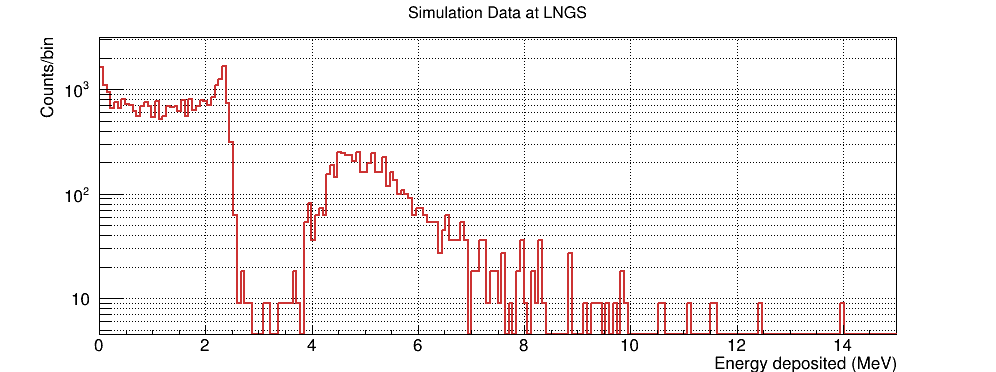

In [19]:
c1_1 = TCanvas('c1_1','',1000,400)
c1_1.cd()

gStyle.SetPalette(kBird) # Colorblind-friendly palette 

sim_root = TH1D('sim_root','',bins,hmin,hmax) # Sim. data [MeV]
fill_hist(sim_root, sim_mev)

sim_root.Draw("hist") 

sim_root.SetTitle("Simulation Data at LNGS")
sim_root.GetXaxis().SetTitle("Energy deposited (MeV)")
sim_root.GetXaxis().SetLabelSize(.05)
sim_root.GetXaxis().SetTitleSize(.05)
sim_root.GetYaxis().SetTitle("Counts/bin")
sim_root.GetYaxis().SetLabelSize(.05)
sim_root.GetYaxis().SetTitleSize(.05)
sim_root.GetYaxis().SetTitleOffset(.65)
sim_root.Scale(9)
sim_root.SetLineWidth(2)
sim_root.SetLineColor(kRed-3)

gPad.SetLogy()
gPad.SetGrid()
gStyle.SetOptStat(0)



c1_1.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1_
Warning in <TFile::Append>: Replacing existing TH1: sim_root (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: sim_root (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: lab_root (Potential memory leak).


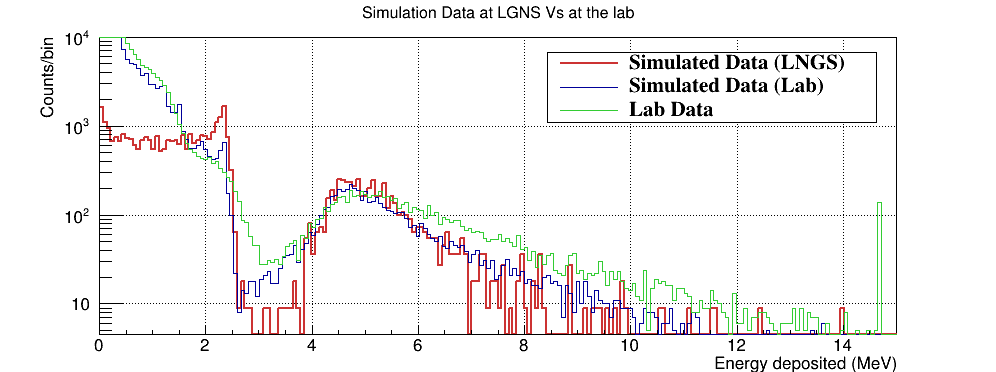

In [20]:
c1_2 = TCanvas('c1_','',1000,400)
c1_2.cd()

gStyle.SetPalette(kBird) # Colorblind-friendly palette 

sim_root = TH1D('sim_root','',bins,hmin,hmax) # Sim. data [MeV]
fill_hist(sim_root, sim_mev)
sim_root_lab = TH1D('sim_root','',bins,hmin,hmax) # Sim. data [MeV]
fill_hist(sim_root_lab, sim_mev_lab)
lab_root = TH1D('lab_root','',bins,hmin,hmax) # Lab data [MeV]
fill_hist(lab_root, lab_mev)
sim_root.Draw("hist") 
sim_root_lab.Draw("same")
lab_root.Draw("same")
sim_root.SetTitle("Simulation Data at LGNS Vs at the lab")
sim_root.SetTitleSize(2)
sim_root.GetXaxis().SetTitle("Energy deposited (MeV)")
sim_root.GetXaxis().SetLabelSize(.05)
sim_root.GetXaxis().SetTitleSize(.05)
sim_root.GetYaxis().SetTitle("Counts/bin")
sim_root.GetYaxis().SetLabelSize(.05)
sim_root.GetYaxis().SetTitleSize(.05)
sim_root.GetYaxis().SetTitleOffset(.65)
sim_root.Scale(9)
sim_root.SetLineWidth(2)
sim_root.SetLineColor(kRed-3)
lab_root.SetLineColor(kGreen-3)
sim_root.SetMaximum(10000)


gPad.SetLogy()
gPad.SetGrid()
gStyle.SetOptStat(0)

legend3 = TLegend(0.55,0.67,0.88,0.86)
legend3.AddEntry(sim_root,"Simulated Data (LNGS)","l")
legend3.AddEntry(sim_root_lab,"Simulated Data (Lab)","l")
legend3.AddEntry(lab_root,"Lab Data","l")
legend3.Draw()

legend3.SetTextFont(20)  
legend3.SetTextSize(0.06)  


c1_2.Draw()

### ATTEMPT 1: Constant sigma model


In [21]:
# Define the const. smearing function
# Takes in data in units of [MeV], output in [MeV]
def smear_const(dat_mev):
    dat_pe = dat_mev * pe_mev # Convert from [MeV] to [PE]
    dat_smeared = np.random.normal(loc=dat_pe, scale = sig662*pe_mev) # Has units [PE]
    dat_smeared = dat_smeared/pe_mev # Convert from [PE] to [MeV]
    return dat_smeared

### Plot with the constant sigma model

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2_1
Warning in <TFile::Append>: Replacing existing TH1: const_smear (Potential memory leak).


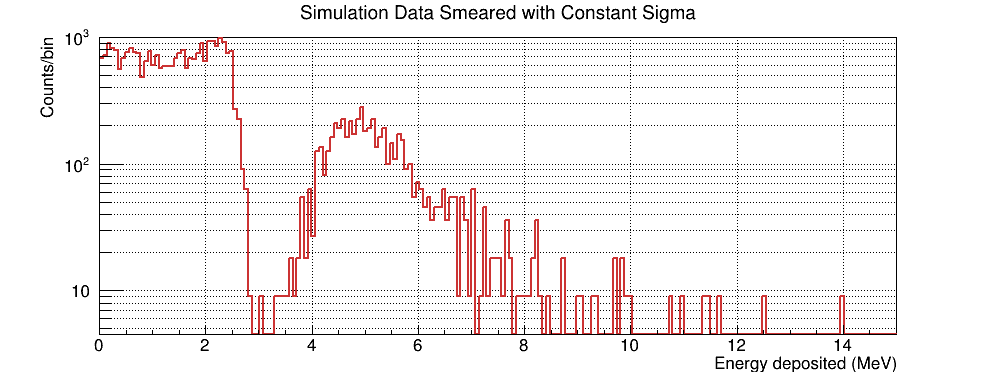

In [22]:
c2_1 = TCanvas('c2_1','',1000,400)
c2_1.cd()

gStyle.SetPalette(kBird) # Colorblind-friendly palette 

const_smear = TH1D('const_smear','',bins,hmin,hmax)
fill_hist(const_smear,smear_const(sim_mev))
const_smear.Draw("hist") 

const_smear.Draw("hist") 
const_smear.SetTitle("Simulation Data Smeared with Constant Sigma")
const_smear.GetXaxis().SetTitle("Energy deposited (MeV)")
const_smear.GetXaxis().SetLabelSize(.05)
const_smear.GetXaxis().SetTitleSize(.05)
const_smear.GetYaxis().SetTitle("Counts/bin")
const_smear.GetYaxis().SetLabelSize(.05)
const_smear.GetYaxis().SetTitleSize(.05)
const_smear.GetYaxis().SetTitleOffset(.65)
const_smear.Scale(9)
const_smear.SetLineWidth(2)
const_smear.SetLineColor(kRed-3)
const_smear.SetMaximum(1000)

gPad.SetLogy()
gPad.SetGrid()
gStyle.SetOptStat(0)


c2_1.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2_2
Warning in <TFile::Append>: Replacing existing TH1: const_smear (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: const_smear_lab (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: lab_smear_const (Potential memory leak).


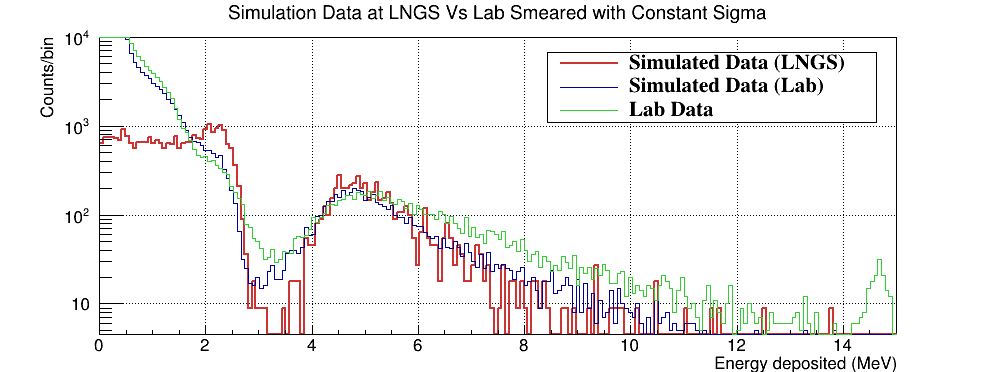

In [23]:
c2_2 = TCanvas('c2_2','',1000,400)
c2_2.cd()

gStyle.SetPalette(kBird) # Colorblind-friendly palette 

const_smear = TH1D('const_smear','',bins,hmin,hmax)
fill_hist(const_smear,smear_const(sim_mev))
const_smear.Draw("hist") 
const_smear_lab = TH1D('const_smear_lab','',bins,hmin,hmax)
fill_hist(const_smear_lab,smear_const(sim_mev_lab))
const_smear_lab.Draw("same")
lab_smear_const = TH1D('lab_smear_const','',bins,hmin,hmax) # Lab data [MeV]
fill_hist(lab_smear_const, smear_const(lab_mev))
lab_smear_const.Draw("same")

const_smear.SetTitle("Simulation Data at LNGS Vs Lab Smeared with Constant Sigma")
const_smear.GetXaxis().SetTitle("Energy deposited (MeV)")
const_smear.GetXaxis().SetLabelSize(.05)
const_smear.GetXaxis().SetTitleSize(.05)
const_smear.GetYaxis().SetTitle("Counts/bin")
const_smear.GetYaxis().SetLabelSize(.05)
const_smear.GetYaxis().SetTitleSize(.05)
const_smear.GetYaxis().SetTitleOffset(.65)
const_smear.Scale(9)
const_smear.SetLineWidth(2)
const_smear.SetLineColor(kRed-3)
lab_smear_const.SetLineColor(kGreen-3)
const_smear.SetMaximum(10000)

gPad.SetLogy()
gPad.SetGrid()
gStyle.SetOptStat(0)

legend3 = TLegend(0.55,0.67,0.88,0.86)
legend3.AddEntry(const_smear,"Simulated Data (LNGS)","l")
legend3.AddEntry(const_smear_lab,"Simulated Data (Lab)","l")
legend3.AddEntry(lab_smear_const,"Lab Data","l")
legend3.Draw()

legend3.SetTextFont(20)  
legend3.SetTextSize(0.06)  


c2_2.Draw()

### ATTEMPT 2: Linear sigma model
$\sigma^2$ is attempted to be modeled using the assumption that is scales linearly with energy (in PE). By this assumption, the following mathematical relationship is used to extrapolate the value of $\sigma$ at 1 PE:

$$\sigma_{PE} = \frac{\sigma_{662\text{KeV}}}{0.662} E_{PE}$$

where $\sigma_{662\text{KeV}}$ is denoted by the previously-declared sig662 constant. Different smearing is applied to muons and gammas, the muons having an additional $x$-axis displacement of +16 PE. Moreover, because $\sigma^2$ is linear, the scale of the Normal distribution will take the form:

$$\text{scale} = a \sqrt{\sigma_{1\text{PE}} E_{PE}}$$

where $a$ is a scalar value.

In [24]:
sig1pe = (sig662*pe_mev) / (.662*pe_mev) # Assuming that sigma scales linearly, calculate its
                                         # value at 1 PE based on the value of sig662.

# Calculate the coefficient for the square root fn that will ensure sigma has value of sig662 at .662 KeV
# Denote this scalar by 'a'

a = (sig662*pe_mev) / np.sqrt(sig1pe*.662*pe_mev)

In [25]:
# Define the linear smearing function
# Takes in data in units of [MeV], x-axis shift in units of [PE], output in [MeV]
def smear_lin(dat_mev, dis_pe):
    dat_pe = dat_mev * pe_mev # Convert from [MeV] to [PE]
    dat_smeared = np.random.normal(loc=dat_pe, scale = a*np.power(sig1pe * dat_pe, 0.5)) + dis_pe # [PE]
    dat_smeared = dat_smeared/pe_mev # Convert from [PE] to [MeV]
    return dat_smeared

# Check if smearing gives correct value of sigma at 662 KeV.
print("Linearly scaled sigma model at 662 KeV: ", a*np.power(sig1pe * .331 * pe_mev, 0.5) / pe_mev)
print("Reference value: ", sig662)

Linearly scaled sigma model at 662 KeV:  0.11320779566796625
Reference value:  0.1601


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3_1
Warning in <TFile::Append>: Replacing existing TH1: lin_smear (Potential memory leak).


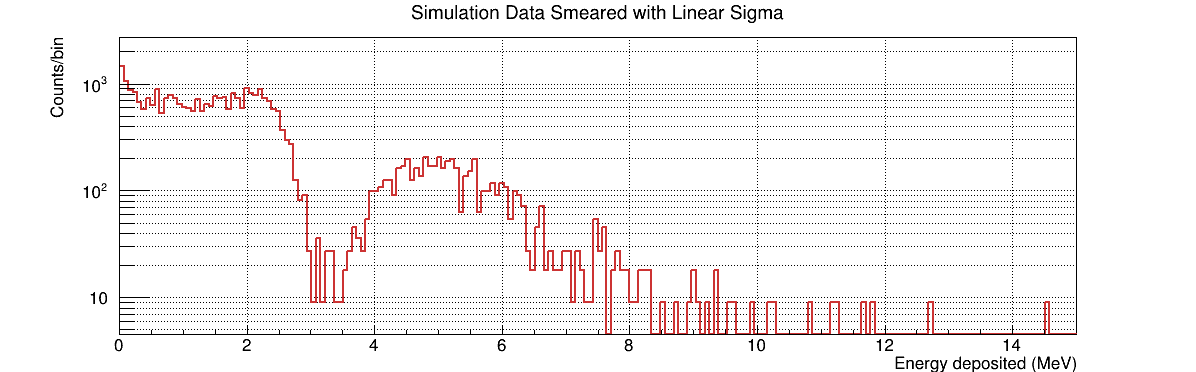

In [26]:
c3_1 = TCanvas('c3_1','',1200,400)
c3_1.cd()

gStyle.SetPalette(kBird) # Colorblind-friendly palette 
lin_smear = TH1D('lin_smear','',bins,hmin,hmax) # Declare TH1 for full spectrum
fill_hist(lin_smear, smear_lin(sim_mev, 0))
 

lin_smear.Draw("hist") 
lin_smear.SetTitle("Simulation Data Smeared with Linear Sigma")
lin_smear.GetXaxis().SetTitle("Energy deposited (MeV)")
lin_smear.GetXaxis().SetLabelSize(.05)
lin_smear.GetXaxis().SetTitleSize(.05)
lin_smear.GetYaxis().SetTitle("Counts/bin")
lin_smear.GetYaxis().SetLabelSize(.05)
lin_smear.GetYaxis().SetTitleSize(.05)
lin_smear.GetYaxis().SetTitleOffset(0.65)
lin_smear.Scale(9)
lin_smear.SetLineWidth(2)
lin_smear.SetLineColor(kRed-3)

gPad.SetLogy()
gPad.SetGrid()
gStyle.SetOptStat(0)


c3_1.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3_2
Warning in <TFile::Append>: Replacing existing TH1: lin_smear (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: lin_smear_lab (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: lab_smear_lin (Potential memory leak).


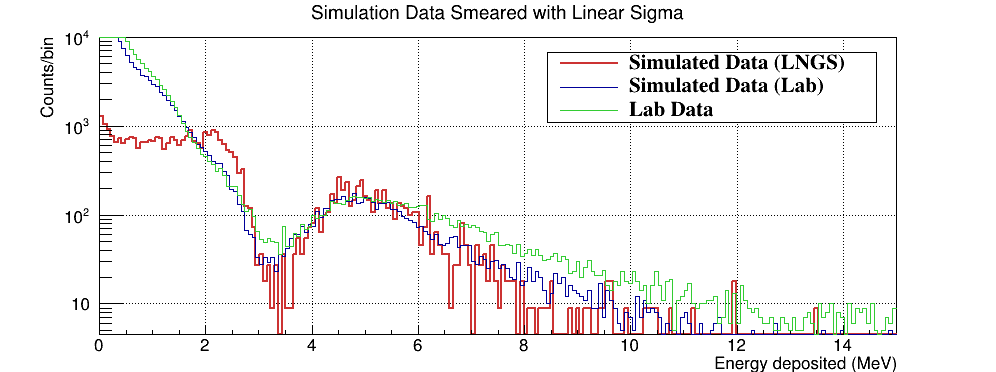

In [27]:
c3_2 = TCanvas('c3_2','',1000,400)
c3_2.cd()

gStyle.SetPalette(kBird) # Colorblind-friendly palette 
lin_smear = TH1D('lin_smear','',bins,hmin,hmax) # Declare TH1 for full spectrum
fill_hist(lin_smear, smear_lin(sim_mev, 0))
lin_smear.Draw("hist") 
lin_smear_lab = TH1D('lin_smear_lab','',bins,hmin,hmax)
fill_hist(lin_smear_lab,smear_lin(sim_mev_lab, 0))
lin_smear_lab.Draw("same")
lab_smear_lin = TH1D('lab_smear_lin','',bins,hmin,hmax) # Lab data [MeV]
fill_hist(lab_smear_lin, smear_lin(lab_mev, 0))
lab_smear_lin.Draw("same")
 
lin_smear.SetTitle("Simulation Data Smeared with Linear Sigma")
lin_smear.GetXaxis().SetTitle("Energy deposited (MeV)")
lin_smear.GetXaxis().SetLabelSize(.05)
lin_smear.GetXaxis().SetTitleSize(.05)
lin_smear.GetYaxis().SetTitle("Counts/bin")
lin_smear.GetYaxis().SetLabelSize(.05)
lin_smear.GetYaxis().SetTitleSize(.05)
lin_smear.GetYaxis().SetTitleOffset(0.65)
lin_smear.Scale(9)
lin_smear.SetLineWidth(2)
lin_smear.SetLineColor(kRed-3)
lab_smear_lin.SetLineColor(kGreen-3)
lin_smear.SetMaximum(10000)


legend3 = TLegend(0.55,0.67,0.88,0.86)
legend3.AddEntry(lin_smear,"Simulated Data (LNGS)","l")
legend3.AddEntry(lin_smear_lab,"Simulated Data (Lab)","l")
legend3.AddEntry(lab_smear_lin,"Lab Data","l")
legend3.Draw()

legend3.SetTextFont(20)  
legend3.SetTextSize(0.06)  

gPad.SetLogy()
gPad.SetGrid()
gStyle.SetOptStat(0)


c3_2.Draw()

In [28]:
def normalize_histogram(histogram):
    integral = histogram.Integral(lx,ux)

    if integral != 0.0:
        histogram.Scale(1.0/integral)
    return histogram

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4


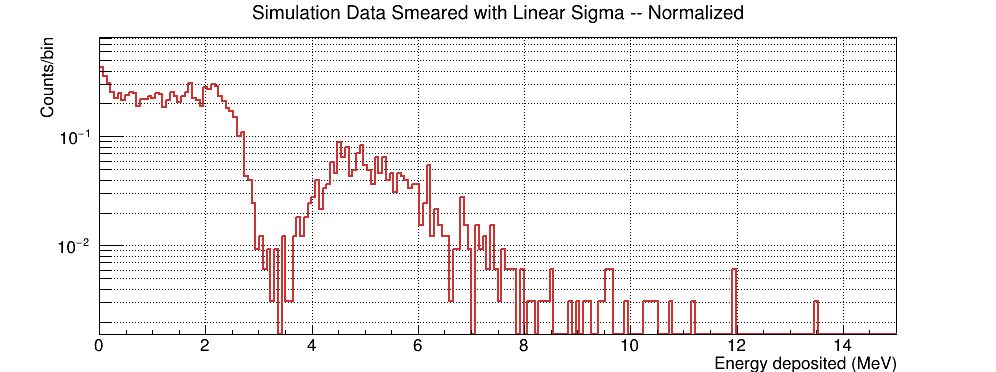

In [29]:
lx = int(0.1/R) # [MeV]
ux = int(2.6/R) # [MeV]

c4 = TCanvas('c4','',1000,400)
c4.cd()
sim_norm = TH1D('sim_norm','',bins,hmin,hmax)

sim_norm = normalize_histogram(lin_smear)

gStyle.SetPalette(kBird) # Colorblind-friendly palette 
sim_norm.Draw("hist") 
 
lin_smear.SetTitle("Simulation Data Smeared with Linear Sigma -- Normalized")
lin_smear.GetXaxis().SetTitle("Energy deposited (MeV)")
lin_smear.GetXaxis().SetLabelSize(.05)
lin_smear.GetXaxis().SetTitleSize(.05)
lin_smear.GetYaxis().SetTitle("Counts/bin")
lin_smear.GetYaxis().SetLabelSize(.05)
lin_smear.GetYaxis().SetTitleSize(.05)
lin_smear.GetYaxis().SetTitleOffset(0.65)
lin_smear.Scale(9)
lin_smear.SetLineWidth(2)
lin_smear.SetLineColor(kRed-3)


gPad.SetLogy()
gPad.SetGrid()
gStyle.SetOptStat(0)

c4.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3_2


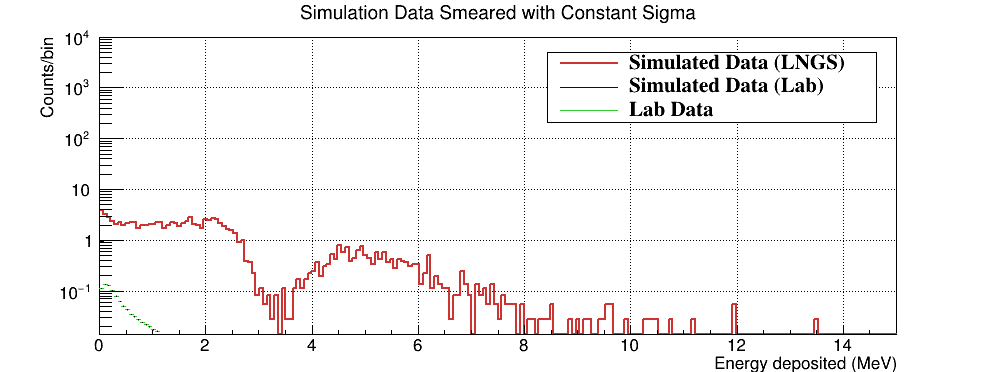

In [30]:
c4_2 = TCanvas('c3_2','',1000,400)
c4_2.cd()

gStyle.SetPalette(kBird) # Colorblind-friendly palette 

sim_norm.Draw("hist") 
sim_norm_lab = TH1D('sim_norm_lab','',bins,hmin,hmax)
sim_norm_lab = normalize_histogram(lin_smear_lab)
lab_norm = TH1D('sim_norm','',bins,hmin,hmax)
lab_norm = normalize_histogram(lab_smear_lin)

sim_norm_lab.Draw("same")
lab_norm.Draw("same")
 
sim_norm.SetTitle("Simulation Data Smeared with Constant Sigma")
sim_norm.GetXaxis().SetTitle("Energy deposited (MeV)")
sim_norm.GetXaxis().SetLabelSize(.05)
sim_norm.GetXaxis().SetTitleSize(.05)
sim_norm.GetYaxis().SetTitle("Counts/bin")
sim_norm.GetYaxis().SetLabelSize(.05)
sim_norm.GetYaxis().SetTitleSize(.05)
sim_norm.GetYaxis().SetTitleOffset(0.65)
sim_norm.Scale(9)
sim_norm.SetLineWidth(2)
sim_norm.SetLineColor(kRed-3)
lab_norm.SetLineColor(kGreen-3)
sim_norm.SetMaximum(10000)


legend3 = TLegend(0.55,0.67,0.88,0.86)
legend3.AddEntry(sim_norm,"Simulated Data (LNGS)","l")
legend3.AddEntry(sim_norm_lab,"Simulated Data (Lab)","l")
legend3.AddEntry(lab_norm,"Lab Data","l")
legend3.Draw()

legend3.SetTextFont(20)  
legend3.SetTextSize(0.06)  

gPad.SetLogy()
gPad.SetGrid()
gStyle.SetOptStat(0)


c4_2.Draw()

In [1]:
rate = 0.51*0.5